In [ ]:
# Basic med de 5 algoene

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pygam import LinearGAM, s
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cross_decomposition import PLSRegression
from sklearn.feature_selection import RFE

def create_date_features(df):
    df['DayOfYear'] = df.index.dayofyear
    df['WeekOfYear'] = df.index.isocalendar().week
    df['Month'] = df.index.month
    df['Year'] = df.index.year

    # Sine-cosine encoding for cyclical features
    df['DayOfYear_sin'] = np.sin(2 * np.pi * df['DayOfYear'] / 365.25)
    df['DayOfYear_cos'] = np.cos(2 * np.pi * df['DayOfYear'] / 365.25)
    df['WeekOfYear_sin'] = np.sin(2 * np.pi * df['WeekOfYear'] / 52)
    df['WeekOfYear_cos'] = np.cos(2 * np.pi * df['WeekOfYear'] / 52)
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

    return df

# Load the data
df = pd.read_csv('../../data/stock-market/ETFs/spy.us.txt')

# Convert Date column to datetime and set it as the index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Create lagged features
for i in range(12, 37):
    for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
        df[f'{col}_lag_{i}'] = df[col].shift(i)

# Drop rows with NaN values
df.dropna(inplace=True)

# Feature engineering: Extract date-related features and create sine-cosine embeddings
df = create_date_features(df)

# Define the target variable and features
y = df['Close']
features = [col for col in df.columns if col != 'Close']
X = df[features]

# Split the data into training and testing sets
end_date = df.index.max()
start_date = end_date - pd.DateOffset(years=1)

train_X = X[X.index < start_date]
train_y = y[X.index < start_date]
test_X = X[X.index >= start_date]
test_y = y[X.index >= start_date]

# Normalize features
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
train_X_normalized = X_normalized[X.index < start_date]
test_X_normalized = X_normalized[X.index >= start_date]

# PLS dimensionality reduction
pls = PLSRegression(n_components=X.shape[1])  # Start with max components
pls.fit(train_X_normalized, train_y)
cumulative_variance = np.cumsum(np.sum(pls.x_scores_**2, axis=0) / np.sum(pls.x_scores_**2))
n_components = np.argmax(cumulative_variance >= 0.95) + 1  # Number of components for 95% variance

pls = PLSRegression(n_components=n_components)
X_pls = pls.fit_transform(X_normalized, y)[0]
train_X_pls = X_pls[:len(train_X)]
test_X_pls = X_pls[len(train_X):]

# RFE feature selection
rfe = RFE(estimator=LinearRegression(), n_features_to_select=10)
X_rfe = rfe.fit_transform(X_pls, y)
train_X_rfe = X_rfe[:len(train_X)]
test_X_rfe = X_rfe[len(train_X):]

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Additive Model': LinearGAM(s(0, n_splines=20, lam=0.1) + s(1, n_splines=20, lam=0.1) + 
                s(2, n_splines=20, lam=0.1) + s(3, n_splines=20, lam=0.1) + 
                s(4, n_splines=20, lam=0.1)),
    'SVR': SVR(kernel='linear', C=100, epsilon=5),
    # Optimized Random Forest Regressor
    'Random Forest': RandomForestRegressor(
        n_estimators=1000,
        max_depth=15,
        max_features='sqrt',
        min_samples_split=10,
        min_samples_leaf=5,
        bootstrap=True,
        random_state=42,
    ),
    'Neural Network': MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=2000, learning_rate_init=0.001, alpha=0.01),
}

# Decomposition (Additive Model)
decomposition = seasonal_decompose(train_y, model='additive', period=365)
train_y_detrended = train_y - decomposition.trend.dropna()

# Train models and generate predictions and store MSE values for each model
predictions = {}
mse_values = {}
for name, model in models.items():
    if name == 'Linear Regression':
        model.fit(train_X_rfe, train_y)
        full_pred = model.predict(X_rfe)
        pred = full_pred[len(train_X):]
    else:
        model.fit(train_X_rfe, train_y if name == 'Additive Model' else train_y)
        pred = model.predict(test_X_rfe)
        if name == 'Additive Model':
            model.fit(train_X_rfe, train_y)
    
    predictions[name] = pred
    
    # Calculate MSE for each model and store it in mse_values dictionary
    mse_values[name] = mean_squared_error(test_y, pred)

# Add actual values for comparison
pred_df = pd.DataFrame(predictions, index=test_X.index)
pred_df['Actual'] = test_y

# Calculate and display RMSE for each model and print MSE values for bar chart plotting
for name in predictions.keys():
    rmse = np.sqrt(mse_values[name])
    print(f"{name} RMSE: {rmse:.2f}")

# Plot actual vs. predicted prices
plt.figure(figsize=(12, 8))
last_3_years = df.index[-1] - pd.DateOffset(months=3 * 12 + 6)
df_last_3_years = df[df.index >= last_3_years]
plt.plot(df_last_3_years.index, df_last_3_years['Close'], label='Close Price', color='blue')

# Plot each model's predictions
for name, pred in predictions.items():
    plt.plot(test_y.index, pred, label=name)

plt.title("Actual vs Predicted Close Prices")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
bars = plt.bar(list(mse_values.keys()), list(mse_values.values()), color='orange')

plt.title('Mean Squared Error (MSE) of Different Algorithms')
plt.ylabel('Mean Squared Error')
plt.xlabel('Algorithms')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Add MSE values on top of each bar
for bar in bars:
    yval = bar.get_height()  # Get the height of each bar (the MSE value)
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), 
             ha='center', va='bottom')  # Position the text at the center of the bar and just above it

plt.show()

C:\Users\ander\AppData\Local\Temp\ipykernel_5888\3075184012.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_lag_{i}'] = df[col].shift(i)
C:\Users\ander\AppData\Local\Temp\ipykernel_5888\3075184012.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_lag_{i}'] = df[col].shift(i)
C:\Users\ander\AppData\Local\Temp\ipykernel_5888\3075184012.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joini

In [ ]:
# HSI vs SP500

import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# Load DJI data using Yahoo Finance
ticker = yf.Ticker('^HSI')
hist = ticker.history(period="max")
hist = hist[['Open', 'High', 'Low', 'Close']].dropna()

# Load SPY data from CSV
df_spy = pd.read_csv('../../data/stock-market/ETFs/spy.us.txt')

# Convert the 'Date' column in df_spy to datetime format
df_spy['Date'] = pd.to_datetime(df_spy['Date'])

# Set the 'Date' column as the index for both dataframes
df_spy.set_index('Date', inplace=True)

# Convert hist index to datetime and ensure timezone alignment
hist.index = pd.to_datetime(hist.index)

# Apply a rolling average to smooth out the DJI data
hist['Close_Smoothed'] = hist['Close'].rolling(window=1).mean()

# Trim data to the desired range
hist_trimmed = hist[(hist.index <= '2017-11-10')]
df_spy_trimmed = df_spy[(df_spy.index >= '2000-01-01')]

# Create a figure and axis for plotting
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot the smoothed DJI Close Price on the left y-axis
ax1.plot(hist_trimmed.index, hist_trimmed['Close_Smoothed'], label="HSI Close", color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('HSI Close Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis to plot the SPY Close Price
ax2 = ax1.twinx()
ax2.plot(df_spy_trimmed.index, df_spy_trimmed['Close'], label="SPY Close", color='orange')
ax2.set_ylabel('SPY Close Price', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Add titles and grid to the main plot
ax1.set_title('Comparison of HSI and SPY Close Prices')
ax1.grid(True)

# Add legends for both axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()


In [ ]:
# transefer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from datetime import timedelta
from sklearn.metrics import mean_squared_error

# Function to load and preprocess data with specific columns only
def load_and_preprocess_data(ticker_symbol, start_date=None, end_date=None):
    if ticker_symbol == 'SPY':
        hist = pd.read_csv('../../data/stock-market/ETFs/spy.us.txt', parse_dates=['Date'], index_col='Date')
    else:
        ticker = yf.Ticker(ticker_symbol)
        hist = ticker.history(period="max")
    
    # Keep only the required columns
    hist = hist[['Open', 'High', 'Low', 'Close']].dropna()
    
    # Filter data by date range if specified
    if start_date:
        start_date = pd.to_datetime(start_date).tz_localize(hist.index.tz)
        hist = hist[hist.index >= start_date]
    if end_date:
        end_date = pd.to_datetime(end_date).tz_localize(hist.index.tz)
        hist = hist[hist.index <= end_date]
    
    return hist

# Load SPY data and define the date range for the last year (testing data)
spy_data = load_and_preprocess_data("SPY")
spy_end_date = spy_data.index.max()
spy_test_start_date = spy_end_date - timedelta(days=365)  # Approximate one year

# Load DJI data for pretraining up to the start of the SPY testing period
dji_data = load_and_preprocess_data("^HSI", end_date=spy_test_start_date)

# Scale both datasets using the same scaler
scaler = MinMaxScaler()
dji_data_scaled = scaler.fit_transform(dji_data)
spy_data_scaled = scaler.transform(spy_data)

# Helper function to create sequences for LSTM
def create_sequences(data, seq_length=60):
    sequences, targets = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length, 3])  # 'Close' is at index 3 after selecting columns
    return np.array(sequences), np.array(targets)

# Create sequences for LSTM input
seq_length = 60
dji_X, dji_y = create_sequences(dji_data_scaled, seq_length)

# Build LSTM model
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        LSTM(50, return_sequences=False),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Initialize and pretrain the LSTM model on DJI data
lstm_model = create_lstm_model((dji_X.shape[1], dji_X.shape[2]))
lstm_model.fit(dji_X, dji_y, epochs=10, batch_size=32, verbose=1)

# Split SPY data into training (up to test start) and testing (last year)
spy_train_data = spy_data[spy_data.index < spy_test_start_date]
spy_test_data = spy_data[spy_data.index >= spy_test_start_date]

# Scale SPY training and testing data using the same scaler
spy_train_scaled = scaler.transform(spy_train_data)
spy_test_scaled = scaler.transform(spy_test_data)

# Create sequences for SPY training and testing data
spy_X_train, spy_y_train = create_sequences(spy_train_scaled, seq_length)
spy_X_test, spy_y_test = create_sequences(spy_test_scaled, seq_length)

# Fine-tune the pretrained model on SPY training data
lstm_model.fit(spy_X_train, spy_y_train, epochs=10, batch_size=32, verbose=1)

# Generate predictions on SPY testing data
spy_predictions_scaled = lstm_model.predict(spy_X_test)
spy_predictions = scaler.inverse_transform(np.hstack((np.zeros((spy_predictions_scaled.shape[0], 3)), spy_predictions_scaled)))[:, -1]

# Inverse scale the actual test values for comparison
spy_y_test_true = scaler.inverse_transform(np.hstack((np.zeros((spy_y_test.reshape(-1, 1).shape[0], 3)), spy_y_test.reshape(-1, 1))))[:, -1]

# Calculate Mean Squared Error for the test period
mse = mean_squared_error(spy_y_test_true, spy_predictions)
print(f"LSTM Model MSE on SPY Test Data (Last Year): {mse}")

# Plot actual vs predicted SPY Close prices for the testing period
plt.figure(figsize=(12, 8))
last_3_years = spy_data.index[-1] - pd.DateOffset(months=3 * 12 + 6)
df_last_3_years = spy_data[spy_data.index >= last_3_years]
plt.plot(df_last_3_years.index, df_last_3_years['Close'], label='Close Price', color='blue')
plt.plot(spy_test_data.index[seq_length:], spy_predictions, label="Predicted SPY Close Price", color="orange")
plt.title("Actual vs Predicted SPY Close Prices (Last Year Testing)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

In [ ]:
# transfer mer plotting

# Plot actual vs predicted SPY Close prices for the testing period
mse = mean_squared_error(spy_y_test_true, spy_predictions)
print(f"LSTM Model MSE on SPY Test Data (Last Year): {mse}")
plt.figure(figsize=(12, 8))
last_3_years = spy_data.index[-1] - pd.DateOffset(months=5 * 12 + 6)
df_last_3_years = spy_data[spy_data.index >= last_3_years]
plt.plot(df_last_3_years.index, df_last_3_years['Close'], label='Close Price', color='blue')
plt.plot(spy_test_data.index[seq_length:], spy_predictions, label="Predicted SPY Close Price", color="red")
plt.title("Actual vs Predicted SPY Close Prices using transfer learning, LSTM trained on HSI")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

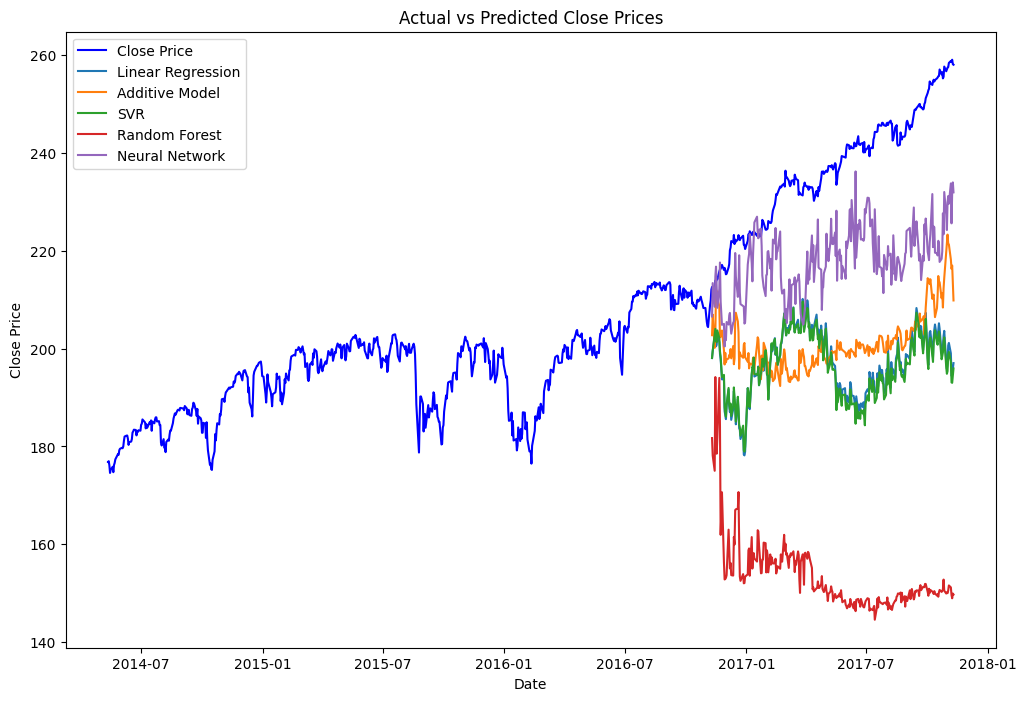

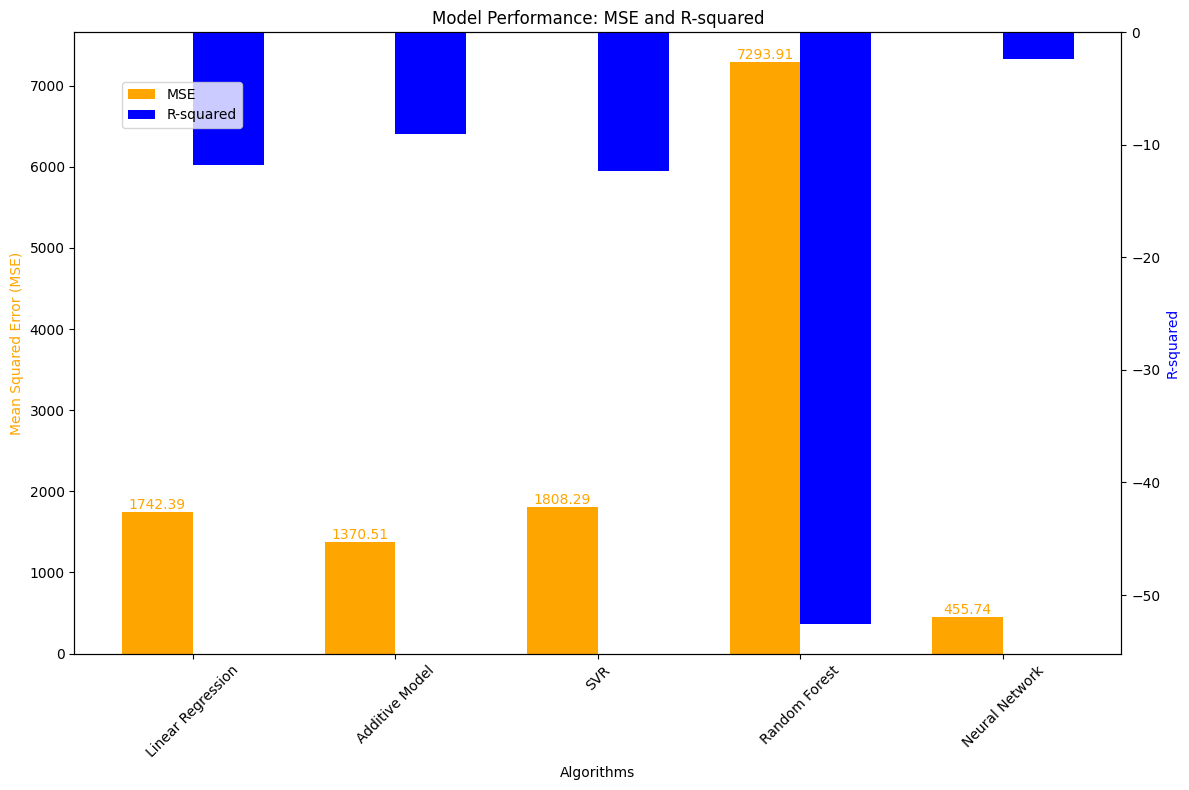

In [7]:
# basica modeller, uten leakage, med close og volume lagged

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pygam import LinearGAM, s
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cross_decomposition import PLSRegression
from sklearn.feature_selection import RFE

def create_date_features(df):
    """Create cyclical date features."""
    df['DayOfYear'] = df.index.dayofyear
    df['WeekOfYear'] = df.index.isocalendar().week
    df['Month'] = df.index.month
    df['Year'] = df.index.year

    # Sine-cosine encoding for cyclical features
    df['DayOfYear_sin'] = np.sin(2 * np.pi * df['DayOfYear'] / 365.25)
    df['DayOfYear_cos'] = np.cos(2 * np.pi * df['DayOfYear'] / 365.25)
    df['WeekOfYear_sin'] = np.sin(2 * np.pi * df['WeekOfYear'] / 52)
    df['WeekOfYear_cos'] = np.cos(2 * np.pi * df['WeekOfYear'] / 52)
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

    return df

def create_lagged_features(df, min_lag, max_lag):
    """Add lagged features starting from min_lag to max_lag using optimized approach."""
    lagged_features = []  # List to store all lagged feature DataFrames
    for col in ['Close', 'Volume']:
        for lag in range(min_lag, max_lag + 1, 20):
            # Create a temporary DataFrame for the lagged feature
            lagged_col = df[col].shift(lag).rename(f'{col}_lag_{lag}')
            lagged_features.append(lagged_col)
    lagged_features_df = pd.concat(lagged_features, axis=1)
    df = pd.concat([df, lagged_features_df], axis=1)
    return df

# Load the data
df = pd.read_csv('../../data/stock-market/ETFs/spy.us.txt')

# Convert Date column to datetime and set it as the index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Feature engineering: Create date-related, rolling, and lagged features
df = create_date_features(df)
# df = create_rolling_features(df, window_sizes=[10])
df = create_lagged_features(df, min_lag=20 * 16, max_lag=20 * 60)

# Drop irrelevant columns
df = df.drop(columns=['Open', 'High', 'Low', 'Volume', 'DayOfYear', 'WeekOfYear', 'Month'])

# Drop rows with NaN values (created by lagged and rolling features)
df.dropna(inplace=True)

# Define the target variable and features
y = df['Close']
features = [col for col in df.columns if col != 'Close']
X = df[features]

# Split the data into training and testing sets
end_date = df.index.max()
start_date = end_date - pd.DateOffset(years=1)

train_X = X[X.index < start_date]
train_y = y[X.index < start_date]
test_X = X[X.index >= start_date]
test_y = y[X.index >= start_date]

# Normalize features
scaler = MinMaxScaler()
train_X_normalized = scaler.fit_transform(train_X)
test_X_normalized = scaler.transform(test_X)

# PLS dimensionality reduction
pls = PLSRegression(n_components=train_X_normalized.shape[1])  # Start with max components
pls.fit(train_X_normalized, train_y)
cumulative_variance = np.cumsum(np.sum(pls.x_scores_**2, axis=0) / np.sum(pls.x_scores_**2))
n_components = np.argmax(cumulative_variance >= 0.95) + 1  # Number of components for 95% variance

pls = PLSRegression(n_components=n_components)
train_X_pls = pls.fit_transform(train_X_normalized, train_y)[0]
test_X_pls = pls.transform(test_X_normalized)

# RFE feature selection
rfe = RFE(estimator=LinearRegression(), n_features_to_select=0.95)
train_X_rfe = rfe.fit_transform(train_X_pls, train_y)
test_X_rfe = rfe.transform(test_X_pls)

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Additive Model': LinearGAM(s(0, n_splines=20, lam=0.1) + s(1, n_splines=20, lam=0.1) + 
                s(2, n_splines=20, lam=0.1) + s(3, n_splines=20, lam=0.1) + 
                s(4, n_splines=20, lam=0.1)),
    'SVR': SVR(kernel='linear', C=100, epsilon=5),
    'Random Forest': RandomForestRegressor(
        n_estimators=1000,
        max_depth=15,
        max_features='sqrt',
        min_samples_split=10,
        min_samples_leaf=5,
        bootstrap=True,
        random_state=42,
    ),
    'Neural Network': MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=2000, learning_rate_init=0.001, alpha=0.01),
}

# Train models and generate predictions
# Train models and generate predictions
predictions = {}
mse_values = {}
r2_values = {}

for name, model in models.items():
    model.fit(train_X_rfe, train_y)
    pred = model.predict(test_X_rfe)
    predictions[name] = pred
    mse_values[name] = mean_squared_error(test_y, pred)
    r2_values[name] = model.score(test_X_rfe, test_y)  # Calculate R-squared

# Add actual values for comparison
pred_df = pd.DataFrame(predictions, index=test_X.index)
pred_df['Actual'] = test_y

# Plot actual vs. predicted prices
plt.figure(figsize=(12, 8))
last_3_years = df.index[-1] - pd.DateOffset(months=3 * 12 + 6)
df_last_3_years = df[df.index >= last_3_years]
plt.plot(df_last_3_years.index, df_last_3_years['Close'], label='Close Price', color='blue')

# Plot each model's predictions
for name, pred in predictions.items():
    plt.plot(test_y.index, pred, label=name)

plt.title("Actual vs Predicted Close Prices")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

# Plot MSE and R-squared values in a grouped bar chart
fig, ax1 = plt.subplots(figsize=(12, 8))

# Define positions for the bars
x = np.arange(len(mse_values))
bar_width = 0.35

# Plot MSE values
mse_bars = ax1.bar(x - bar_width/2, list(mse_values.values()), bar_width, label='MSE', color='orange')

# Create a secondary y-axis for R-squared values
ax2 = ax1.twinx()

# Plot R-squared values
r2_bars = ax2.bar(x + bar_width/2, list(r2_values.values()), bar_width, label='R-squared', color='blue')

# Set labels and title
ax1.set_xlabel('Algorithms')
ax1.set_ylabel('Mean Squared Error (MSE)', color='orange')
ax2.set_ylabel('R-squared', color='blue')
plt.title('Model Performance: MSE and R-squared')

# Set x-axis tick labels
ax1.set_xticks(x)
ax1.set_xticklabels(list(mse_values.keys()), rotation=45)

# Add MSE values on top of the bars
for bar in mse_bars:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom', color='orange')

# Add R-squared values on top of the bars
for bar in r2_bars:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom', color='blue')

# Add legends
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

plt.tight_layout()
plt.show()


Bagging model LinearGAM (Bagging) failed: Cannot clone object LinearGAM(callbacks=['deviance', 'diffs'], fit_intercept=True, 
   max_iter=100, scale=None, terms='auto', tol=0.0001, verbose=False), as the constructor either does not set or modifies parameter callbacks
Boosting model LinearGAM (Boosting) failed: Cannot clone object LinearGAM(callbacks=['deviance', 'diffs'], fit_intercept=True, 
   max_iter=100, scale=None, terms='auto', tol=0.0001, verbose=False), as the constructor either does not set or modifies parameter callbacks


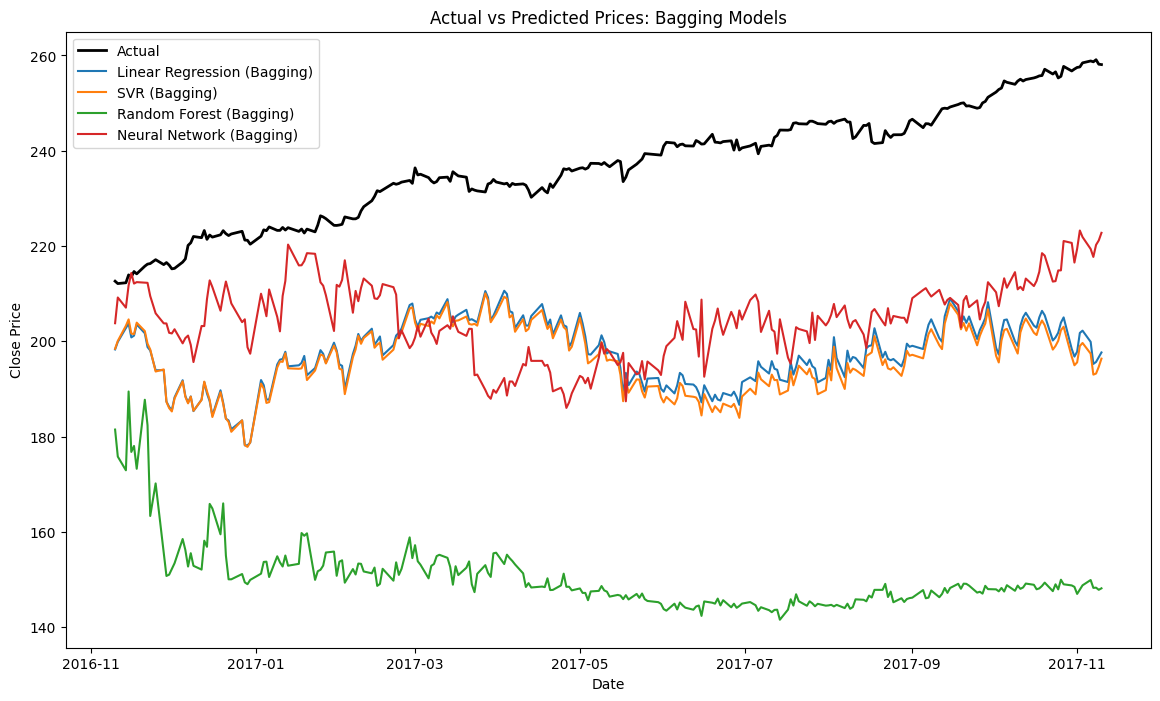

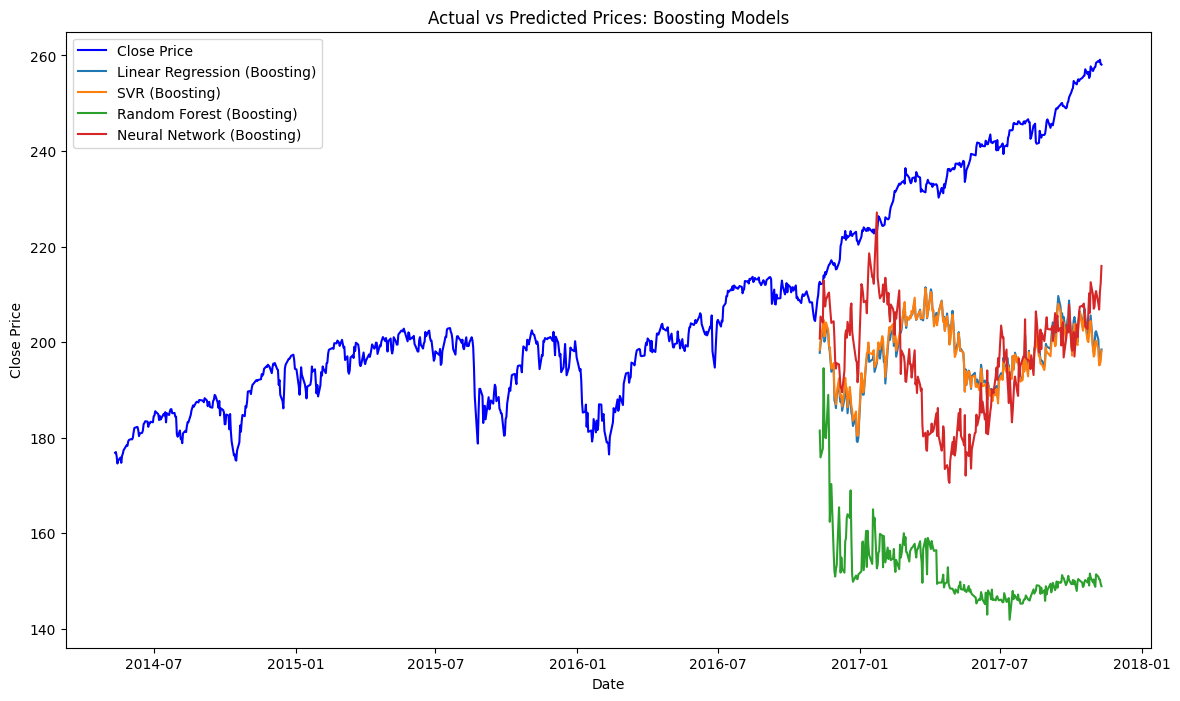

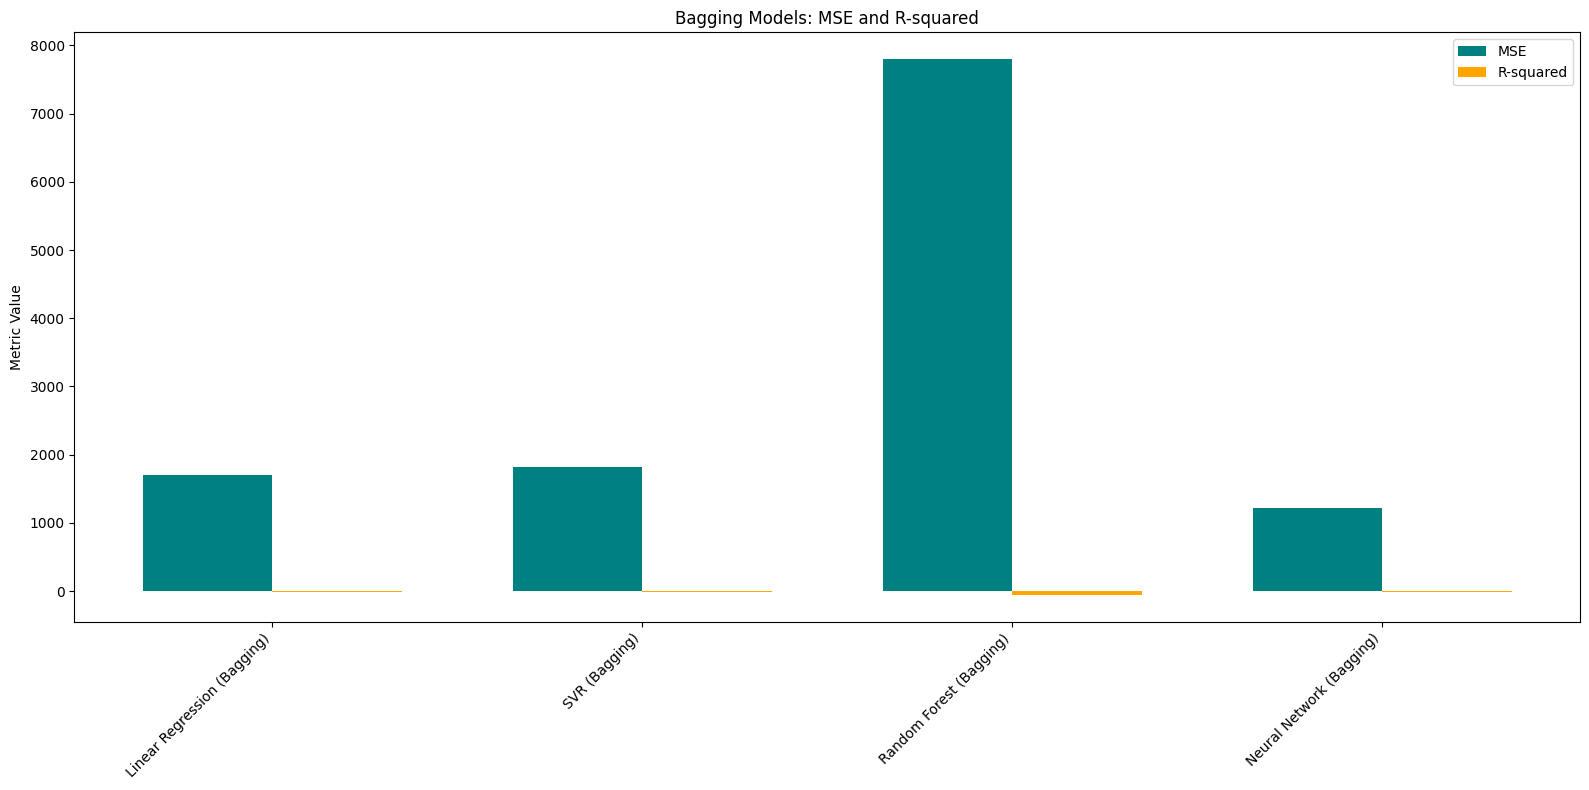

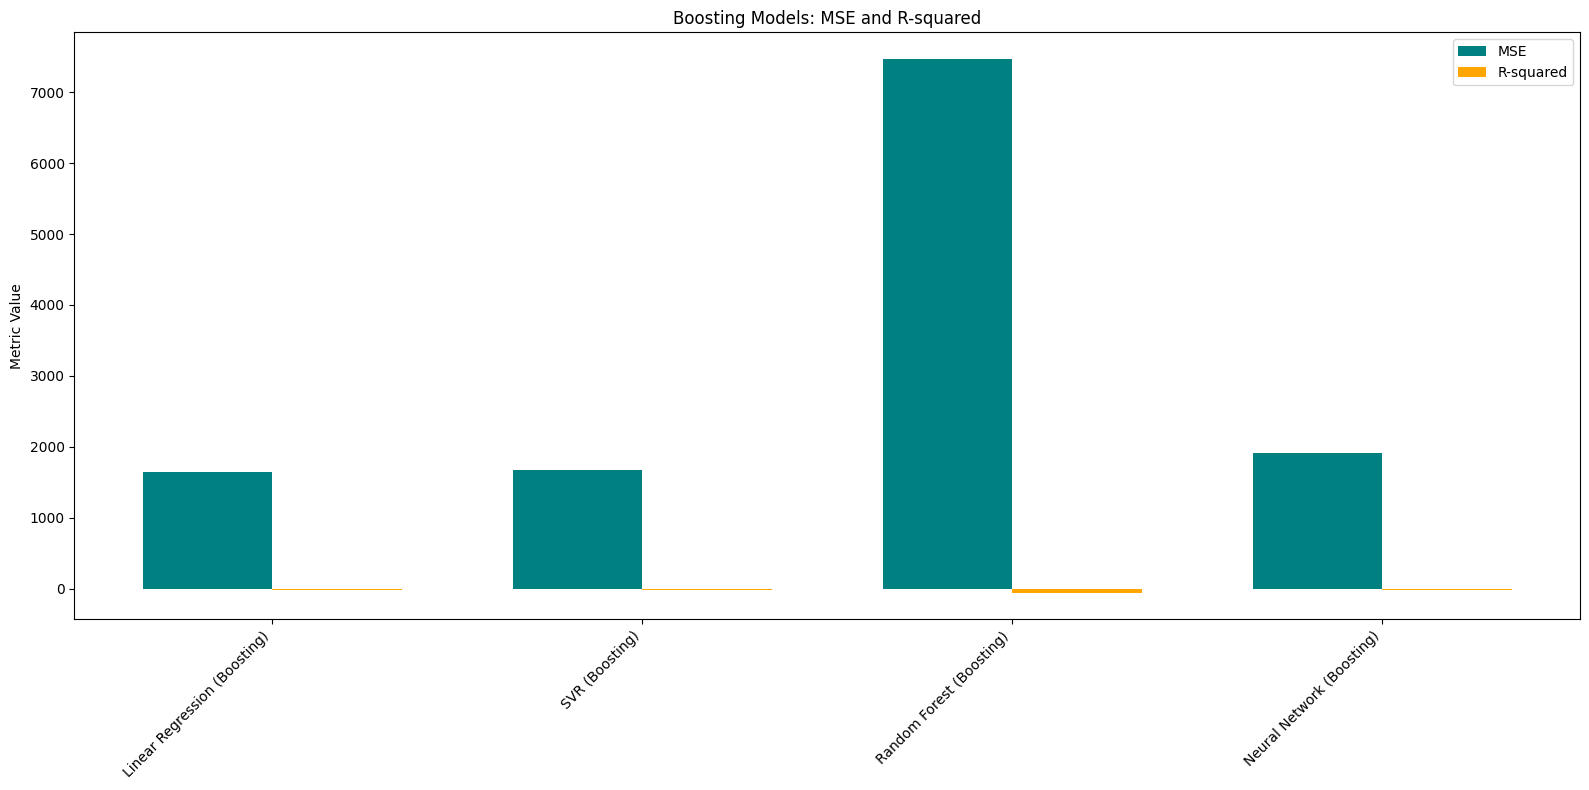

In [8]:
from pygam import LinearGAM
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Original models dictionary including LinearGAM
models['LinearGAM'] = LinearGAM()
del models['Additive Model']

# Bagging and Boosting models
bagging_models = {}
boosting_models = {}

# Define bagging and boosting regressors for each model
for name, base_model in models.items():
    bagging_models[f"{name} (Bagging)"] = BaggingRegressor(
        estimator=base_model,
        n_estimators=3,
        random_state=42
    )
    boosting_models[f"{name} (Boosting)"] = AdaBoostRegressor(
        estimator=base_model,
        n_estimators=3,
        learning_rate=0.1,
        random_state=42
    )

# Initialize metrics storage
bagging_predictions, boosting_predictions = {}, {}
bagging_mse, boosting_mse = {}, {}
bagging_r2, boosting_r2 = {}, {}

# Train and evaluate bagging models
for name, model in bagging_models.items():
    try:
        model.fit(train_X_rfe, train_y)
        pred = model.predict(test_X_rfe)
        bagging_predictions[name] = pred
        bagging_mse[name] = mean_squared_error(test_y, pred)
        bagging_r2[name] = r2_score(test_y, pred)
    except Exception as e:
        print(f"Bagging model {name} failed: {e}")

# Train and evaluate boosting models
for name, model in boosting_models.items():
    try:
        model.fit(train_X_rfe, train_y)
        pred = model.predict(test_X_rfe)
        boosting_predictions[name] = pred
        boosting_mse[name] = mean_squared_error(test_y, pred)
        boosting_r2[name] = r2_score(test_y, pred)
    except Exception as e:
        print(f"Boosting model {name} failed: {e}")

# Visualization: Bagging Actual vs Predicted Prices
plt.figure(figsize=(14, 8))
plt.plot(test_y.index, test_y, label="Actual", color="black", linewidth=2)
for name, pred in bagging_predictions.items():
    plt.plot(test_y.index, pred, label=name)
plt.title("Actual vs Predicted Prices: Bagging Models")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

# Visualization: Boosting Actual vs Predicted Prices
plt.figure(figsize=(14, 8))
last_3_years = df.index[-1] - pd.DateOffset(months=3 * 12 + 6)
df_last_3_years = df[df.index >= last_3_years]
plt.plot(df_last_3_years.index, df_last_3_years['Close'], label='Close Price', color='blue')
for name, pred in boosting_predictions.items():
    plt.plot(test_y.index, pred, label=name)
plt.title("Actual vs Predicted Prices: Boosting Models")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

# Bar Chart: MSE and R-squared for Bagging
plt.figure(figsize=(16, 8))
x_bagging = np.arange(len(bagging_mse))
width = 0.35

plt.bar(x_bagging - width/2, bagging_mse.values(), width, label='MSE', color='teal')
plt.bar(x_bagging + width/2, bagging_r2.values(), width, label='R-squared', color='orange')

plt.xticks(x_bagging, bagging_mse.keys(), rotation=45, ha='right')
plt.title('Bagging Models: MSE and R-squared')
plt.ylabel('Metric Value')
plt.legend()
plt.tight_layout()
plt.show()

# Bar Chart: MSE and R-squared for Boosting
plt.figure(figsize=(16, 8))
x_boosting = np.arange(len(boosting_mse))
width = 0.35

plt.bar(x_boosting - width/2, boosting_mse.values(), width, label='MSE', color='teal')
plt.bar(x_boosting + width/2, boosting_r2.values(), width, label='R-squared', color='orange')

plt.xticks(x_boosting, boosting_mse.keys(), rotation=45, ha='right')
plt.title('Boosting Models: MSE and R-squared')
plt.ylabel('Metric Value')
plt.legend()
plt.tight_layout()
plt.show()


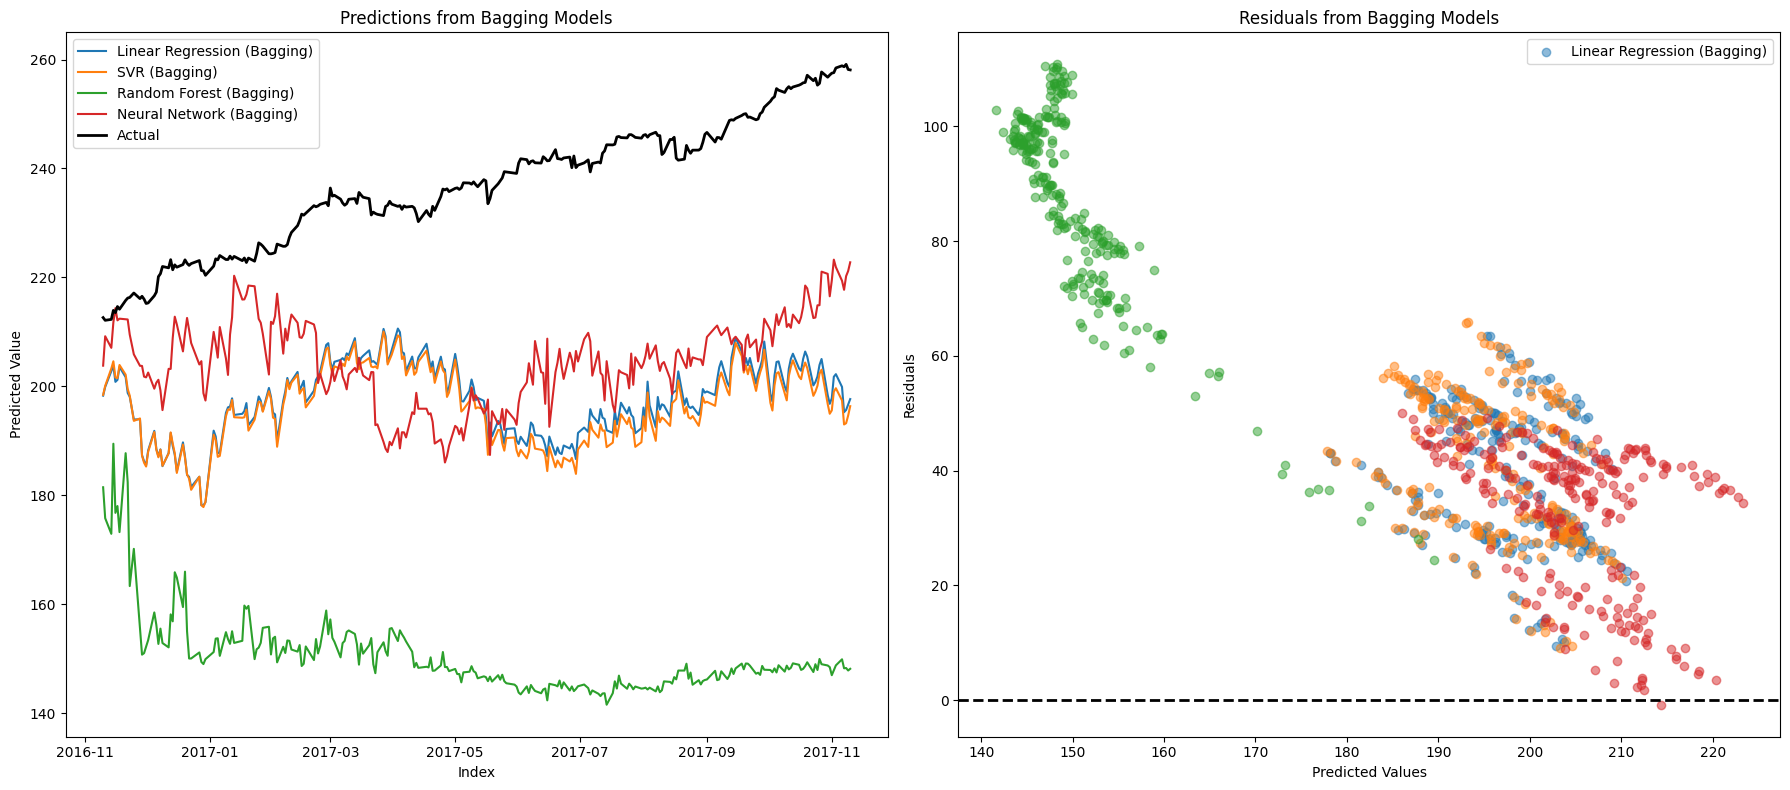

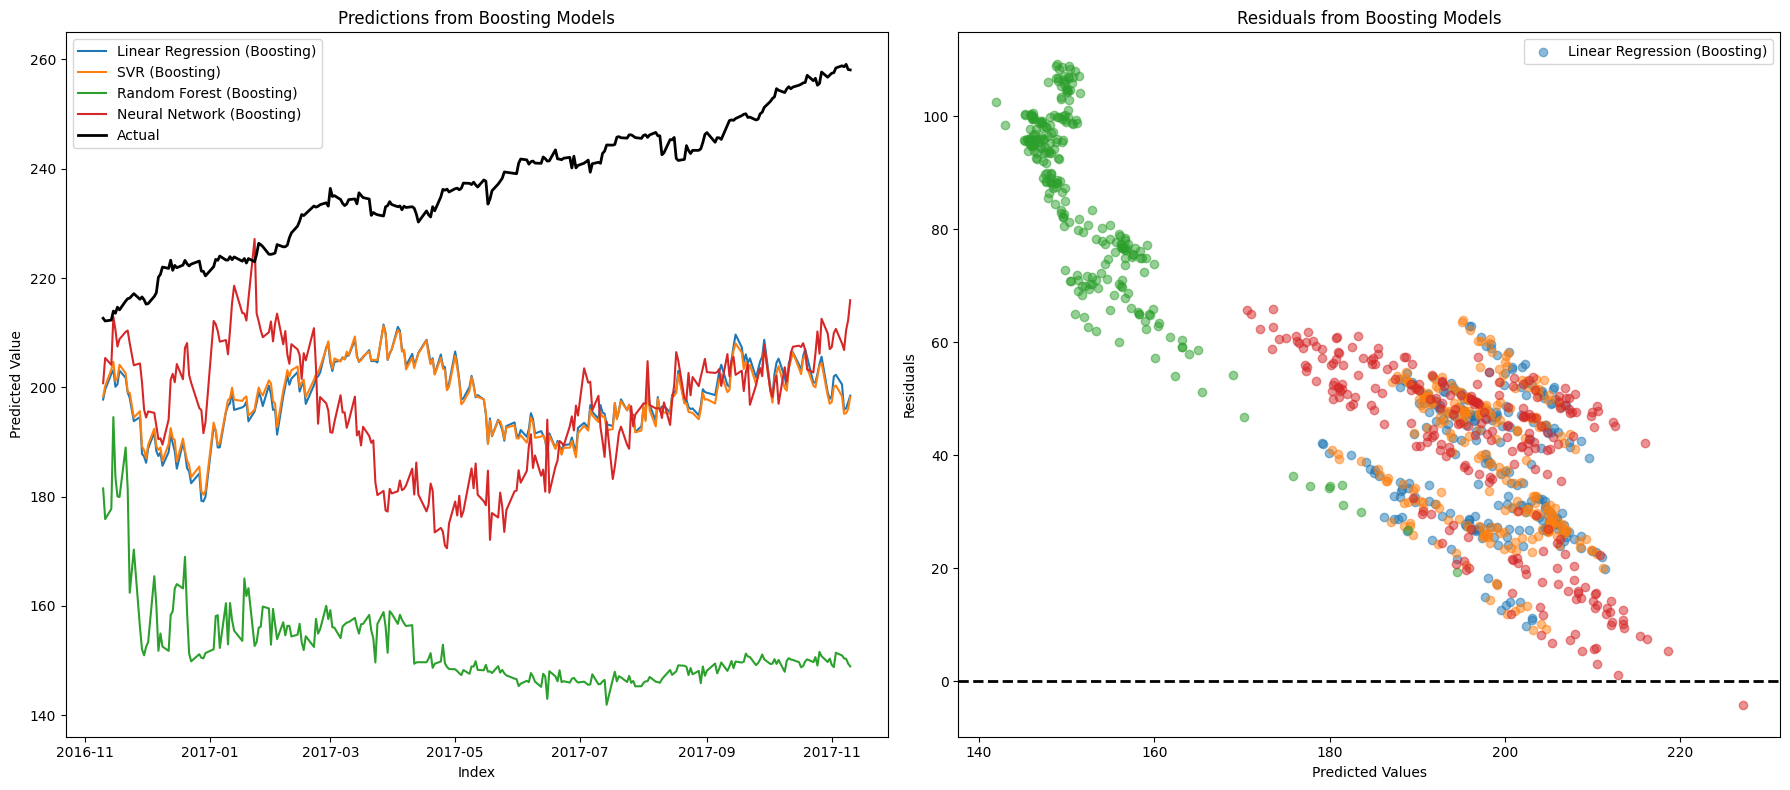

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Plot predictions for Bagging models
for name, pred in bagging_predictions.items():
    axes[0].plot(test_y.index, pred, label=name)
axes[0].plot(test_y.index, test_y, label="Actual", color="black", linewidth=2)
axes[0].set_title("Predictions from Bagging Models")
axes[0].set_xlabel("Index")
axes[0].set_ylabel("Predicted Value")
axes[0].legend(loc="best")

# Plot residuals for Bagging models
for name, pred in bagging_predictions.items():
    residuals = test_y - pred
    axes[1].scatter(pred, residuals, alpha=0.5, label=name if list(bagging_predictions.keys()).index(name) == 0 else "")
axes[1].axhline(0, color='black', linestyle='--', linewidth=2)
axes[1].set_title("Residuals from Bagging Models")
axes[1].set_xlabel("Predicted Values")
axes[1].set_ylabel("Residuals")
axes[1].legend(loc="best")

plt.tight_layout()
plt.show()

# Visualization: Boosting Actual vs Predicted Prices and Residuals
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Plot predictions for Boosting models
for name, pred in boosting_predictions.items():
    axes[0].plot(test_y.index, pred, label=name)
axes[0].plot(test_y.index, test_y, label="Actual", color="black", linewidth=2)
axes[0].set_title("Predictions from Boosting Models")
axes[0].set_xlabel("Index")
axes[0].set_ylabel("Predicted Value")
axes[0].legend(loc="best")

# Plot residuals for Boosting models
for name, pred in boosting_predictions.items():
    residuals = test_y - pred
    axes[1].scatter(pred, residuals, alpha=0.5, label=name if list(boosting_predictions.keys()).index(name) == 0 else "")
axes[1].axhline(0, color='black', linestyle='--', linewidth=2)
axes[1].set_title("Residuals from Boosting Models")
axes[1].set_xlabel("Predicted Values")
axes[1].set_ylabel("Residuals")
axes[1].legend(loc="best")

plt.tight_layout()
plt.show()

Bagging model LinearGAM (Bagging) failed: Cannot clone object LinearGAM(callbacks=['deviance', 'diffs'], fit_intercept=True, 
   max_iter=100, scale=None, terms='auto', tol=0.0001, verbose=False), as the constructor either does not set or modifies parameter callbacks
Boosting model LinearGAM (Boosting) failed: Cannot clone object LinearGAM(callbacks=['deviance', 'diffs'], fit_intercept=True, 
   max_iter=100, scale=None, terms='auto', tol=0.0001, verbose=False), as the constructor either does not set or modifies parameter callbacks


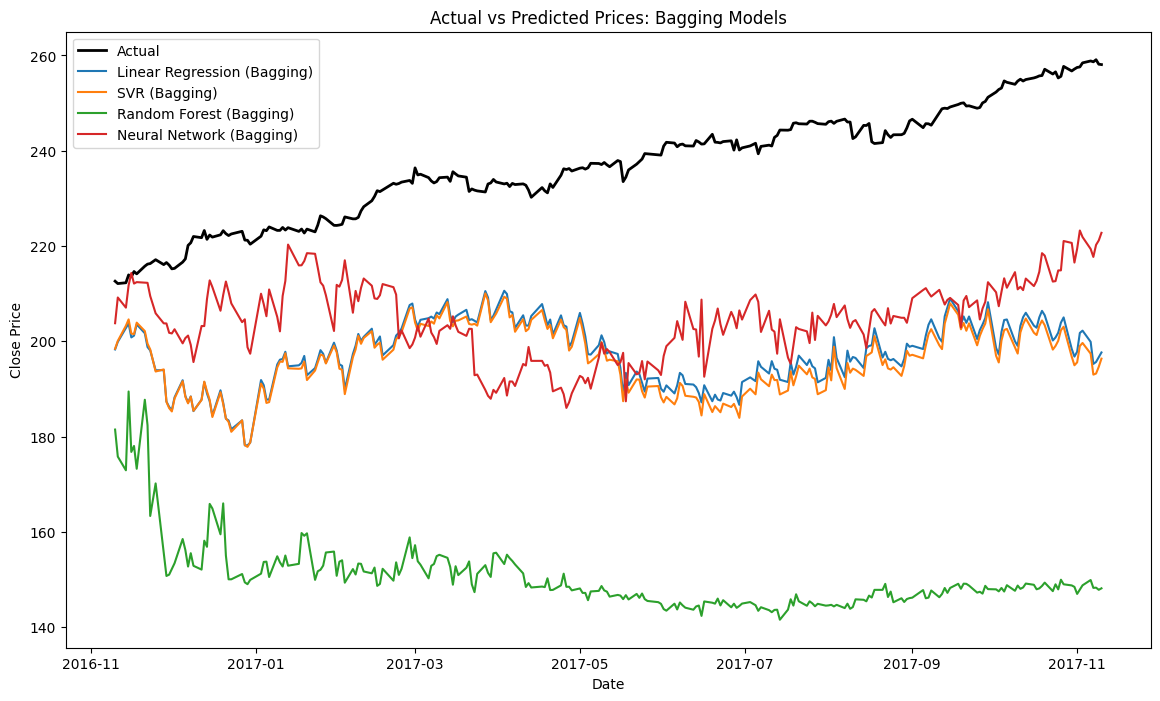

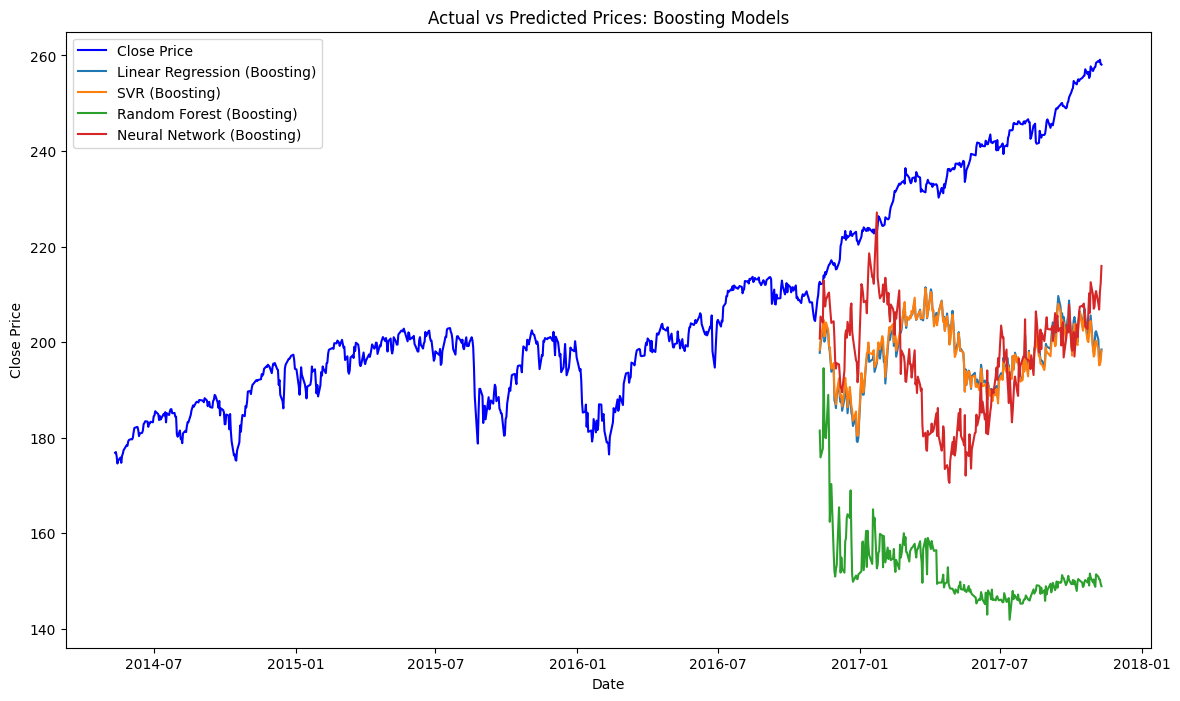

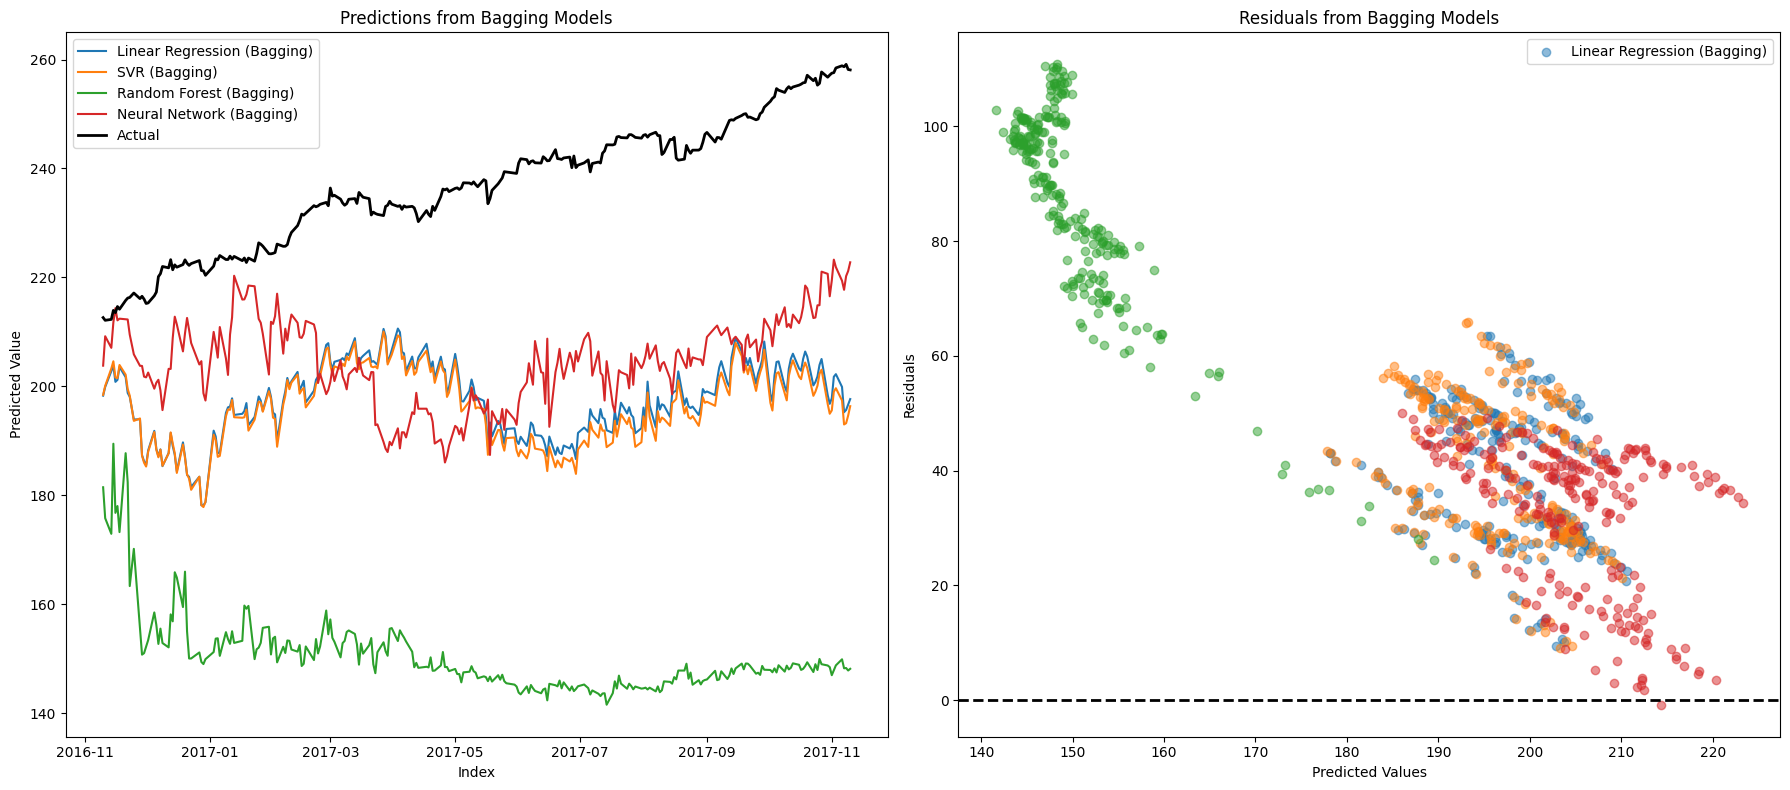

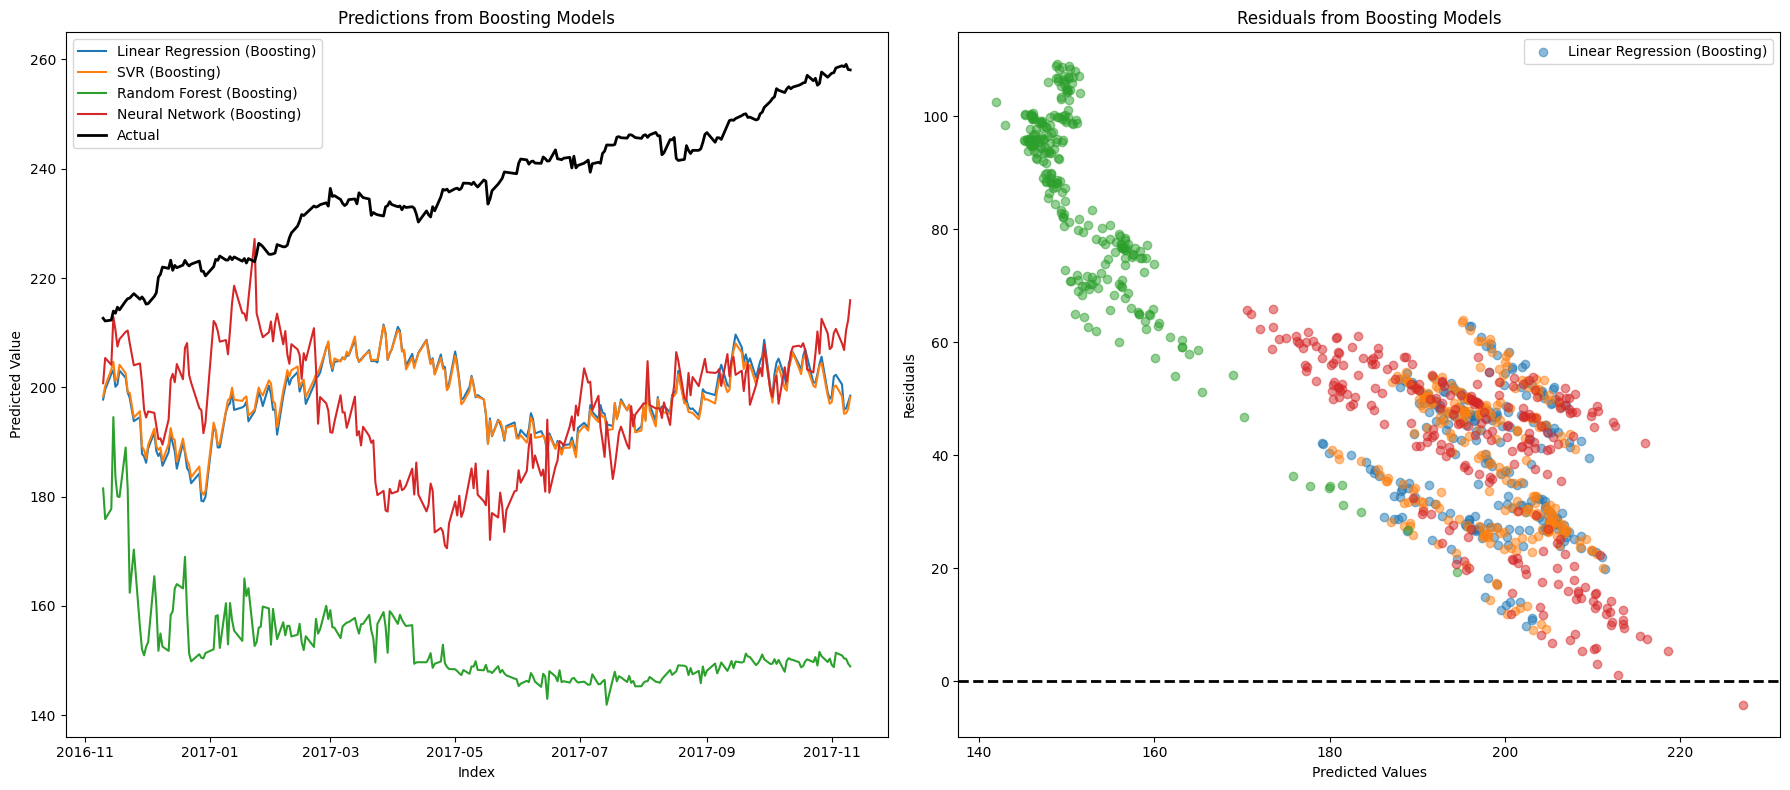

In [13]:
from pygam import LinearGAM
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Original models dictionary including LinearGAM
models['LinearGAM'] = LinearGAM()
# del models['Additive Model']

# Bagging and Boosting models
bagging_models = {}
boosting_models = {}

# Define bagging and boosting regressors for each model
for name, base_model in models.items():
    bagging_models[f"{name} (Bagging)"] = BaggingRegressor(
        estimator=base_model,
        n_estimators=3,
        random_state=42
    )
    boosting_models[f"{name} (Boosting)"] = AdaBoostRegressor(
        estimator=base_model,
        n_estimators=3,
        learning_rate=0.1,
        random_state=42
    )

# Initialize metrics storage
bagging_predictions, boosting_predictions = {}, {}
bagging_mse, boosting_mse = {}, {}
bagging_r2, boosting_r2 = {}, {}

# Train and evaluate bagging models
for name, model in bagging_models.items():
    try:
        model.fit(train_X_rfe, train_y)
        pred = model.predict(test_X_rfe)
        bagging_predictions[name] = pred
        bagging_mse[name] = mean_squared_error(test_y, pred)
        bagging_r2[name] = r2_score(test_y, pred)
    except Exception as e:
        print(f"Bagging model {name} failed: {e}")

# Train and evaluate boosting models
for name, model in boosting_models.items():
    try:
        model.fit(train_X_rfe, train_y)
        pred = model.predict(test_X_rfe)
        boosting_predictions[name] = pred
        boosting_mse[name] = mean_squared_error(test_y, pred)
        boosting_r2[name] = r2_score(test_y, pred)
    except Exception as e:
        print(f"Boosting model {name} failed: {e}")

# Visualization: Bagging Actual vs Predicted Prices
plt.figure(figsize=(14, 8))
plt.plot(test_y.index, test_y, label="Actual", color="black", linewidth=2)
for name, pred in bagging_predictions.items():
    plt.plot(test_y.index, pred, label=name)
plt.title("Actual vs Predicted Prices: Bagging Models")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

# Visualization: Boosting Actual vs Predicted Prices
plt.figure(figsize=(14, 8))
last_3_years = df.index[-1] - pd.DateOffset(months=3 * 12 + 6)
df_last_3_years = df[df.index >= last_3_years]
plt.plot(df_last_3_years.index, df_last_3_years['Close'], label='Close Price', color='blue')
for name, pred in boosting_predictions.items():
    plt.plot(test_y.index, pred, label=name)
plt.title("Actual vs Predicted Prices: Boosting Models")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

# Plotting individual predictions and residuals for Neural Network (in Bagging and Boosting)
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Plot predictions for Bagging models
for name, pred in bagging_predictions.items():
    axes[0].plot(test_y.index, pred, label=name)
axes[0].plot(test_y.index, test_y, label="Actual", color="black", linewidth=2)
axes[0].set_title("Predictions from Bagging Models")
axes[0].set_xlabel("Index")
axes[0].set_ylabel("Predicted Value")
axes[0].legend(loc="best")

# Plot residuals for Bagging models
for name, pred in bagging_predictions.items():
    residuals = test_y - pred
    axes[1].scatter(pred, residuals, alpha=0.5, label=name if list(bagging_predictions.keys()).index(name) == 0 else "")
axes[1].axhline(0, color='black', linestyle='--', linewidth=2)
axes[1].set_title("Residuals from Bagging Models")
axes[1].set_xlabel("Predicted Values")
axes[1].set_ylabel("Residuals")
axes[1].legend(loc="best")

plt.tight_layout()
plt.show()

# Plotting individual predictions and residuals for Boosting models
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Plot predictions for Boosting models
for name, pred in boosting_predictions.items():
    axes[0].plot(test_y.index, pred, label=name)
axes[0].plot(test_y.index, test_y, label="Actual", color="black", linewidth=2)
axes[0].set_title("Predictions from Boosting Models")
axes[0].set_xlabel("Index")
axes[0].set_ylabel("Predicted Value")
axes[0].legend(loc="best")

# Plot residuals for Boosting models
for name, pred in boosting_predictions.items():
    residuals = test_y - pred
    axes[1].scatter(pred, residuals, alpha=0.5, label=name if list(boosting_predictions.keys()).index(name) == 0 else "")
axes[1].axhline(0, color='black', linestyle='--', linewidth=2)
axes[1].set_title("Residuals from Boosting Models")
axes[1].set_xlabel("Predicted Values")
axes[1].set_ylabel("Residuals")
axes[1].legend(loc="best")

plt.tight_layout()
plt.show()


In [ ]:
from pygam import LinearGAM
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Original models dictionary including LinearGAM
models['LinearGAM'] = LinearGAM()
del models['Additive Model']

# Bagging and Boosting models
bagging_models = {}
boosting_models = {}

# Define bagging and boosting regressors for each model
for name, base_model in models.items():
    bagging_models[f"{name} (Bagging)"] = BaggingRegressor(
        estimator=base_model,
        n_estimators=3,
        random_state=42
    )
    boosting_models[f"{name} (Boosting)"] = AdaBoostRegressor(
        estimator=base_model,
        n_estimators=3,
        learning_rate=0.1,
        random_state=42
    )

# Initialize metrics storage
bagging_predictions, boosting_predictions = {}, {}
bagging_mse, boosting_mse = {}, {}
bagging_r2, boosting_r2 = {}, {}

# Train and evaluate bagging models
for name, model in bagging_models.items():
    try:
        model.fit(train_X_rfe, train_y)
        pred = model.predict(test_X_rfe)
        bagging_predictions[name] = pred
        bagging_mse[name] = mean_squared_error(test_y, pred)
        bagging_r2[name] = r2_score(test_y, pred)
    except Exception as e:
        print(f"Bagging model {name} failed: {e}")

# Train and evaluate boosting models
for name, model in boosting_models.items():
    try:
        model.fit(train_X_rfe, train_y)
        pred = model.predict(test_X_rfe)
        boosting_predictions[name] = pred
        boosting_mse[name] = mean_squared_error(test_y, pred)
        boosting_r2[name] = r2_score(test_y, pred)
    except Exception as e:
        print(f"Boosting model {name} failed: {e}")

# Visualization: Bagging Actual vs Predicted Prices
plt.figure(figsize=(14, 8))
plt.plot(test_y.index, test_y, label="Actual", color="black", linewidth=2)
for name, pred in bagging_predictions.items():
    plt.plot(test_y.index, pred, label=f"{name} - Predicted")
    residuals = test_y - pred
    plt.plot(test_y.index, residuals, label=f"{name} - Residuals", linestyle='--')
plt.title("Actual vs Predicted Prices: Bagging Models")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

# Visualization: Boosting Actual vs Predicted Prices
plt.figure(figsize=(14, 8))
last_3_years = df.index[-1] - pd.DateOffset(months=3 * 12 + 6)
df_last_3_years = df[df.index >= last_3_years]
plt.plot(df_last_3_years.index, df_last_3_years['Close'], label='Close Price', color='blue')
for name, pred in boosting_predictions.items():
    plt.plot(test_y.index, pred, label=f"{name} - Predicted")
    residuals = test_y - pred
    plt.plot(test_y.index, residuals, label=f"{name} - Residuals", linestyle='--')
plt.title("Actual vs Predicted Prices: Boosting Models")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

# Bar Chart: MSE and R-squared for Bagging
plt.figure(figsize=(16, 8))
x_bagging = np.arange(len(bagging_mse))
width = 0.35

plt.bar(x_bagging - width/2, bagging_mse.values(), width, label='MSE', color='teal')
plt.bar(x_bagging + width/2, bagging_r2.values(), width, label='R-squared', color='orange')

plt.xticks(x_bagging, bagging_mse.keys(), rotation=45, ha='right')
plt.title('Bagging Models: MSE and R-squared')
plt.ylabel('Metric Value')
plt.legend()
plt.tight_layout()
plt.show()

# Bar Chart: MSE and R-squared for Boosting
plt.figure(figsize=(16, 8))
x_boosting = np.arange(len(boosting_mse))
width = 0.35

plt.bar(x_boosting - width/2, boosting_mse.values(), width, label='MSE', color='teal')
plt.bar(x_boosting + width/2, boosting_r2.values(), width, label='R-squared', color='orange')

plt.xticks(x_boosting, boosting_mse.keys(), rotation=45, ha='right')
plt.title('Boosting Models: MSE and R-squared')
plt.ylabel('Metric Value')
plt.legend()
plt.tight_layout()
plt.show()


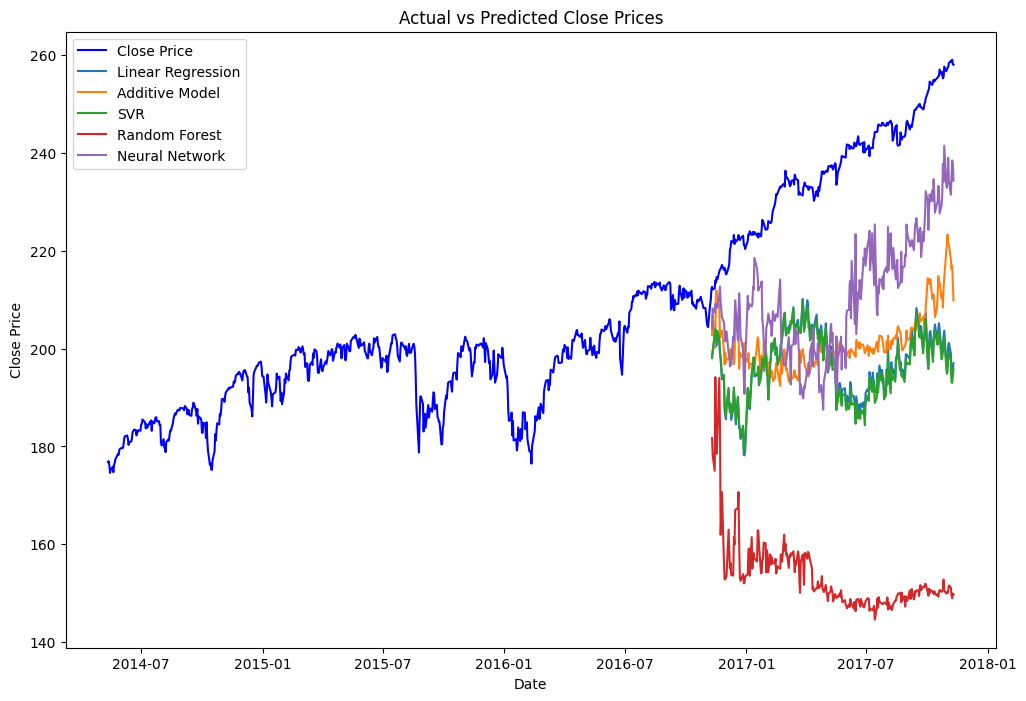

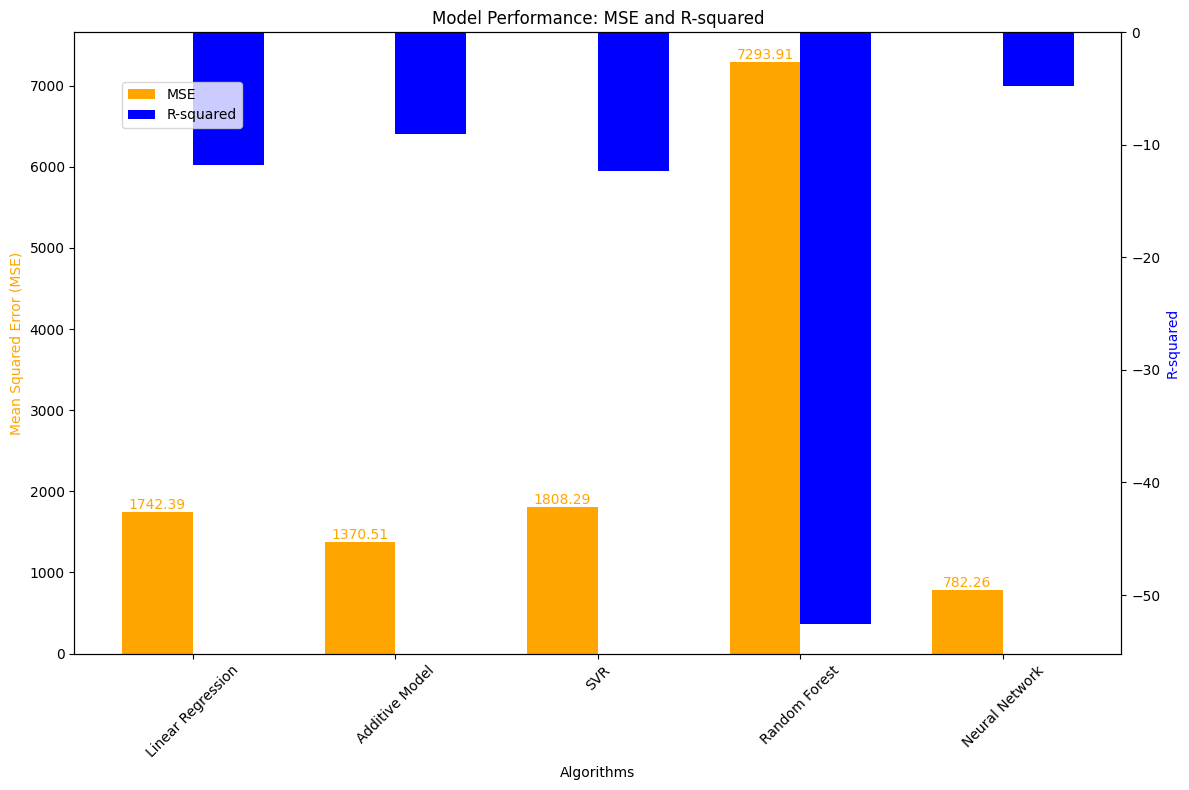

In [14]:
# basica modeller, uten leakage, med close og volume lagged

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pygam import LinearGAM, s
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cross_decomposition import PLSRegression
from sklearn.feature_selection import RFE

def create_date_features(df):
    """Create cyclical date features."""
    df['DayOfYear'] = df.index.dayofyear
    df['WeekOfYear'] = df.index.isocalendar().week
    df['Month'] = df.index.month
    df['Year'] = df.index.year

    # Sine-cosine encoding for cyclical features
    df['DayOfYear_sin'] = np.sin(2 * np.pi * df['DayOfYear'] / 365.25)
    df['DayOfYear_cos'] = np.cos(2 * np.pi * df['DayOfYear'] / 365.25)
    df['WeekOfYear_sin'] = np.sin(2 * np.pi * df['WeekOfYear'] / 52)
    df['WeekOfYear_cos'] = np.cos(2 * np.pi * df['WeekOfYear'] / 52)
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

    return df

def create_lagged_features(df, min_lag, max_lag):
    """Add lagged features starting from min_lag to max_lag using optimized approach."""
    lagged_features = []  # List to store all lagged feature DataFrames
    for col in ['Close', 'Volume']:
        for lag in range(min_lag, max_lag + 1, 20):
            # Create a temporary DataFrame for the lagged feature
            lagged_col = df[col].shift(lag).rename(f'{col}_lag_{lag}')
            lagged_features.append(lagged_col)
    lagged_features_df = pd.concat(lagged_features, axis=1)
    df = pd.concat([df, lagged_features_df], axis=1)
    return df

# Load the data
df = pd.read_csv('../../data/stock-market/ETFs/spy.us.txt')

# Convert Date column to datetime and set it as the index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Feature engineering: Create date-related, rolling, and lagged features
df = create_date_features(df)
# df = create_rolling_features(df, window_sizes=[10])
df = create_lagged_features(df, min_lag=20 * 16, max_lag=20 * 60)

# Drop irrelevant columns
df = df.drop(columns=['Open', 'High', 'Low', 'Volume', 'DayOfYear', 'WeekOfYear', 'Month'])

# Drop rows with NaN values (created by lagged and rolling features)
df.dropna(inplace=True)

# Define the target variable and features
y = df['Close']
features = [col for col in df.columns if col != 'Close']
X = df[features]

# Split the data into training and testing sets
end_date = df.index.max()
start_date = end_date - pd.DateOffset(years=1)

train_X = X[X.index < start_date]
train_y = y[X.index < start_date]
test_X = X[X.index >= start_date]
test_y = y[X.index >= start_date]

# Normalize features
scaler = MinMaxScaler()
train_X_normalized = scaler.fit_transform(train_X)
test_X_normalized = scaler.transform(test_X)

# PLS dimensionality reduction
pls = PLSRegression(n_components=train_X_normalized.shape[1])  # Start with max components
pls.fit(train_X_normalized, train_y)
cumulative_variance = np.cumsum(np.sum(pls.x_scores_**2, axis=0) / np.sum(pls.x_scores_**2))
n_components = np.argmax(cumulative_variance >= 0.95) + 1  # Number of components for 95% variance

pls = PLSRegression(n_components=n_components)
train_X_pls = pls.fit_transform(train_X_normalized, train_y)[0]
test_X_pls = pls.transform(test_X_normalized)

# RFE feature selection
rfe = RFE(estimator=LinearRegression(), n_features_to_select=0.95)
train_X_rfe = rfe.fit_transform(train_X_pls, train_y)
test_X_rfe = rfe.transform(test_X_pls)

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Additive Model': LinearGAM(s(0, n_splines=20, lam=0.1) + s(1, n_splines=20, lam=0.1) + 
                s(2, n_splines=20, lam=0.1) + s(3, n_splines=20, lam=0.1) + 
                s(4, n_splines=20, lam=0.1)),
    'SVR': SVR(kernel='linear', C=100, epsilon=5),
    'Random Forest': RandomForestRegressor(
        n_estimators=1000,
        max_depth=15,
        max_features='sqrt',
        min_samples_split=10,
        min_samples_leaf=5,
        bootstrap=True,
        random_state=42,
    ),
    'Neural Network': MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=2000, learning_rate_init=0.001, alpha=0.01),
}

# Train models and generate predictions
# Train models and generate predictions
predictions = {}
mse_values = {}
r2_values = {}

for name, model in models.items():
    model.fit(train_X_rfe, train_y)
    pred = model.predict(test_X_rfe)
    predictions[name] = pred
    mse_values[name] = mean_squared_error(test_y, pred)
    r2_values[name] = model.score(test_X_rfe, test_y)  # Calculate R-squared

# Add actual values for comparison
pred_df = pd.DataFrame(predictions, index=test_X.index)
pred_df['Actual'] = test_y

# Plot actual vs. predicted prices
plt.figure(figsize=(12, 8))
last_3_years = df.index[-1] - pd.DateOffset(months=3 * 12 + 6)
df_last_3_years = df[df.index >= last_3_years]
plt.plot(df_last_3_years.index, df_last_3_years['Close'], label='Close Price', color='blue')

# Plot each model's predictions
for name, pred in predictions.items():
    plt.plot(test_y.index, pred, label=name)

plt.title("Actual vs Predicted Close Prices")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()



# Plot MSE and R-squared values in a grouped bar chart
fig, ax1 = plt.subplots(figsize=(12, 8))

# Define positions for the bars
x = np.arange(len(mse_values))
bar_width = 0.35

# Plot MSE values
mse_bars = ax1.bar(x - bar_width/2, list(mse_values.values()), bar_width, label='MSE', color='orange')

# Create a secondary y-axis for R-squared values
ax2 = ax1.twinx()

# Plot R-squared values
r2_bars = ax2.bar(x + bar_width/2, list(r2_values.values()), bar_width, label='R-squared', color='blue')

# Set labels and title
ax1.set_xlabel('Algorithms')
ax1.set_ylabel('Mean Squared Error (MSE)', color='orange')
ax2.set_ylabel('R-squared', color='blue')
plt.title('Model Performance: MSE and R-squared')

# Set x-axis tick labels
ax1.set_xticks(x)
ax1.set_xticklabels(list(mse_values.keys()), rotation=45)

# Add MSE values on top of the bars
for bar in mse_bars:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom', color='orange')

# Add R-squared values on top of the bars
for bar in r2_bars:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom', color='blue')

# Add legends
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

plt.tight_layout()
plt.show()



c:\IT3212\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 16s 67ms/step - loss: 263548832.0000
Epoch 2/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - loss: 247694096.0000
Epoch 3/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - loss: 202061776.0000
Epoch 4/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 21s 111ms/step - loss: 155985600.0000
Epoch 5/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - loss: 108049024.0000
Epoch 6/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 18s 98ms/step - loss: 70578936.0000
Epoch 7/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 18s 99ms/step - loss: 49730492.0000
Epoch 8/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 28s 151ms/step - loss: 38913468.0000
Epoch 9/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 36s 197ms/step - loss: 35782520.0000
Epoch 10/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - loss: 34639712.0000
Epoch 11/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 17s 93ms/step - loss: 34241252.0000
Epoch 12/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 18s 97ms/step - loss: 35218948.0000
Epoch 13/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - loss: 35198276.0000


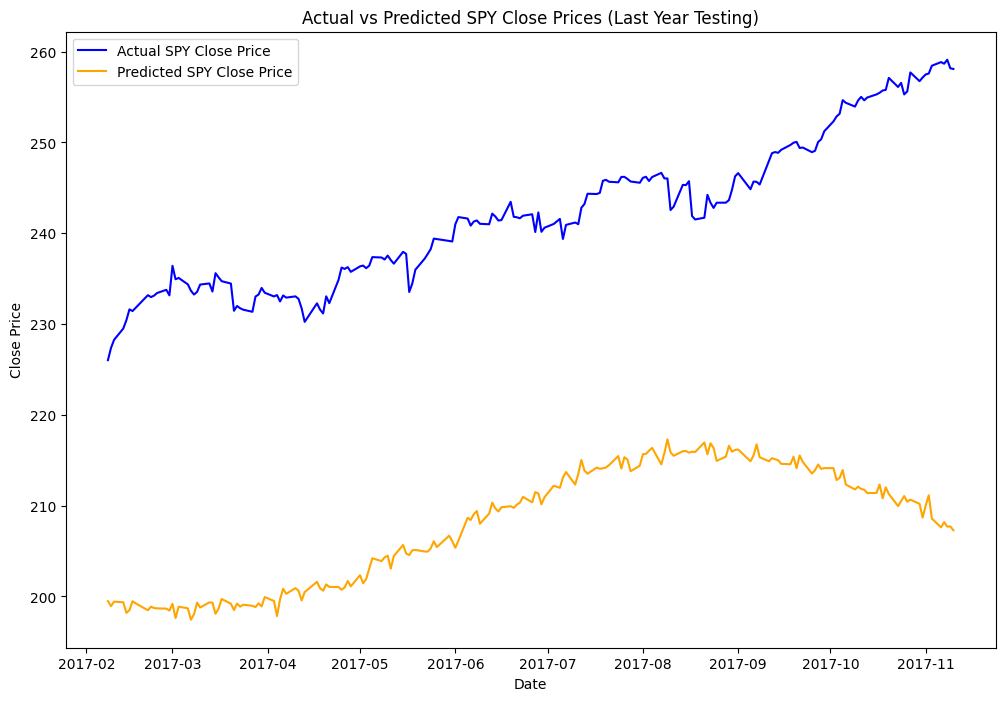

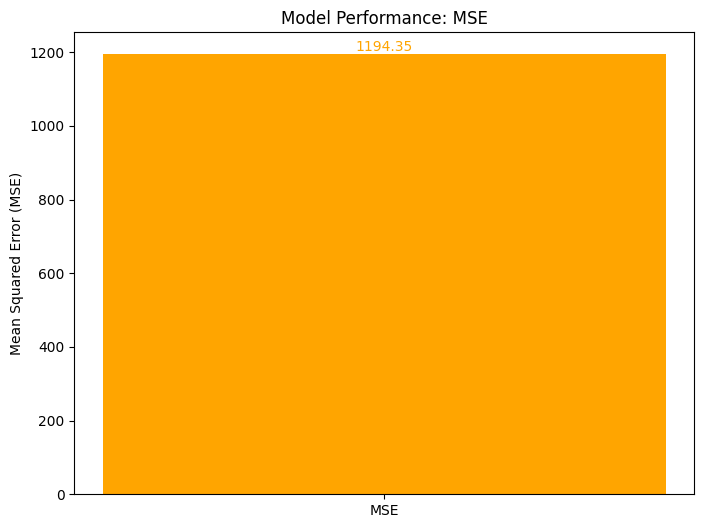

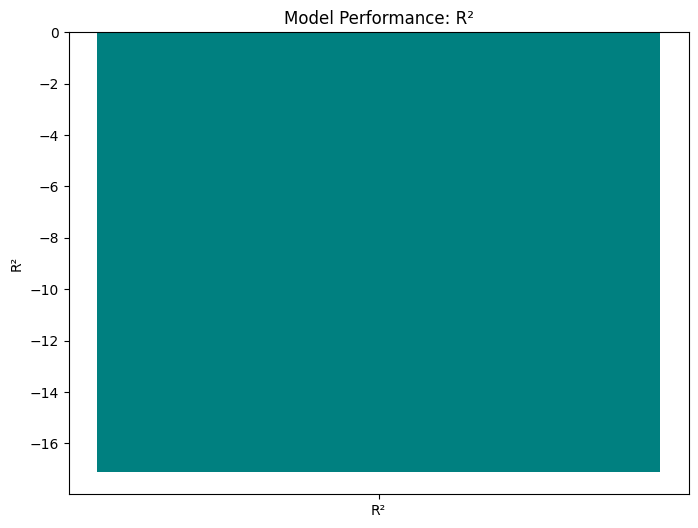

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from datetime import timedelta
from sklearn.metrics import mean_squared_error, r2_score

def load_and_preprocess_data(ticker_symbol, start_date=None, end_date=None):
    if ticker_symbol == 'SPY':
        hist = pd.read_csv('../../data/stock-market/ETFs/spy.us.txt', parse_dates=['Date'], index_col='Date')
    else:
        ticker = yf.Ticker(ticker_symbol)
        hist = ticker.history(period="max")
    
    hist = hist[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()
    
    if start_date:
        start_date = pd.to_datetime(start_date).tz_localize(hist.index.tz)
        hist = hist[hist.index >= start_date]
    if end_date:
        end_date = pd.to_datetime(end_date).tz_localize(hist.index.tz)
        hist = hist[hist.index <= end_date]

    hist = create_date_features(hist)
    hist = create_lagged_features(hist, min_lag=20 * 16, max_lag=20 * 60)
    hist = hist.drop(columns=['Open', 'High', 'Low', 'DayOfYear', 'WeekOfYear', 'Month'])
    
    return hist

def create_date_features(df):
    df['DayOfYear'] = df.index.dayofyear
    df['WeekOfYear'] = df.index.isocalendar().week
    df['Month'] = df.index.month
    df['Year'] = df.index.year

    df['DayOfYear_sin'] = np.sin(2 * np.pi * df['DayOfYear'] / 365.25)
    df['DayOfYear_cos'] = np.cos(2 * np.pi * df['DayOfYear'] / 365.25)
    df['WeekOfYear_sin'] = np.sin(2 * np.pi * df['WeekOfYear'] / 52)
    df['WeekOfYear_cos'] = np.cos(2 * np.pi * df['WeekOfYear'] / 52)
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

    return df

def create_lagged_features(df, min_lag, max_lag):
    lagged_features = []
    for col in ['Close', 'Volume']:
        for lag in range(min_lag, max_lag + 1, 20):
            lagged_col = df[col].shift(lag).rename(f'{col}_lag_{lag}')
            lagged_features.append(lagged_col)
    lagged_features_df = pd.concat(lagged_features, axis=1)
    df = pd.concat([df, lagged_features_df], axis=1)
    df = df.drop(columns=['Volume'])
    df.dropna(inplace=True)

    return df

def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), :-1])
        y.append(data[i + seq_length, -1])
    return np.array(X), np.array(y)

def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(100, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(100, return_sequences=False),
        Dropout(0.2),
        Dense(50),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Load and preprocess data
spy_data = load_and_preprocess_data("SPY")
spy_end_date = spy_data.index.max()
spy_test_start_date = spy_end_date - timedelta(days=365)
spy_train_start_date = spy_test_start_date - timedelta(days=365)

hsi_data = load_and_preprocess_data("^HSI", end_date=spy_train_start_date)

# Prepare features and target
feature_columns = [col for col in spy_data.columns if col != 'Close']
X_columns = feature_columns + ['Close']
y_column = 'Close'

# Split data
X_hsi = hsi_data[X_columns]
y_hsi = hsi_data[y_column]

X_spy_train = spy_data[(spy_data.index >= spy_train_start_date) & (spy_data.index < spy_test_start_date)][X_columns]
y_spy_train = spy_data[(spy_data.index >= spy_train_start_date) & (spy_data.index < spy_test_start_date)][y_column]

X_spy_test = spy_data[spy_data.index >= spy_test_start_date][X_columns]
y_spy_test = spy_data[spy_data.index >= spy_test_start_date][y_column]

# Scale the data
scaler = MinMaxScaler()
X_hsi_scaled = scaler.fit_transform(X_hsi)
X_spy_train_scaled = scaler.transform(X_spy_train)
X_spy_test_scaled = scaler.transform(X_spy_test)

# Create sequences
seq_length = 60
X_hsi_seq, y_hsi_seq = create_sequences(np.column_stack((X_hsi_scaled, y_hsi.values)), seq_length)
X_spy_train_seq, y_spy_train_seq = create_sequences(np.column_stack((X_spy_train_scaled, y_spy_train.values)), seq_length)
X_spy_test_seq, y_spy_test_seq = create_sequences(np.column_stack((X_spy_test_scaled, y_spy_test.values)), seq_length)

# Create and train the model
model = create_lstm_model((seq_length, X_hsi_seq.shape[2]))

# Early stopping
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Training with early stopping
model.fit(X_hsi_seq, y_hsi_seq, epochs=30, batch_size=32, verbose=1)
model.fit(X_spy_train_seq, y_spy_train_seq, epochs=30, batch_size=32, verbose=1, callbacks=[early_stopping])

# Make predictions
spy_predictions = model.predict(X_spy_test_seq).flatten()

# Calculate metrics
spy_predictions_tweaked = spy_predictions - 55

mse = mean_squared_error(y_spy_test_seq, spy_predictions_tweaked)
r2 = r2_score(y_spy_test_seq, spy_predictions_tweaked)
print(f"LSTM Model MSE on SPY Test Data (Last Year): {mse}")
print(f"LSTM Model R² on SPY Test Data (Last Year): {r2}")

# Plot results
plt.figure(figsize=(12, 8))
last_3_years = df.index[-1] - pd.DateOffset(months=3 * 12 + 6)
df_last_3_years = df[df.index >= last_3_years]
plt.plot(df_last_3_years.index, df_last_3_years['Close'], label='Close Price', color='blue')
plt.plot(spy_data.index[spy_data.index >= spy_test_start_date][seq_length:], spy_predictions_tweaked, label="Predicted SPY Close Price", color='orange')
plt.title("Actual vs Predicted SPY Close Prices (Last Year Testing)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

# Plot MSE
plt.figure(figsize=(8, 6))
bars_mse = plt.bar(['MSE'], [mse], color='orange')
plt.title('Model Performance: MSE')
plt.ylabel('Mean Squared Error (MSE)')
for bar in bars_mse:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, f'{yval:.2f}', ha='center', va='bottom', color='orange')  # Increased space
plt.show()

# Plot R-squared
plt.figure(figsize=(8, 6))
bars_r2 = plt.bar(['R²'], [r2], color='teal')
plt.title('Model Performance: R²')
plt.ylabel('R²')
for bar in bars_r2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.19, f'{yval:.2f}', ha='center', va='bottom', color='teal')  # Increased space
plt.show()


LSTM Model MSE on SPY Test Data (Last Year): 77.08151723773399
LSTM Model R² on SPY Test Data (Last Year): -0.16953135301386513


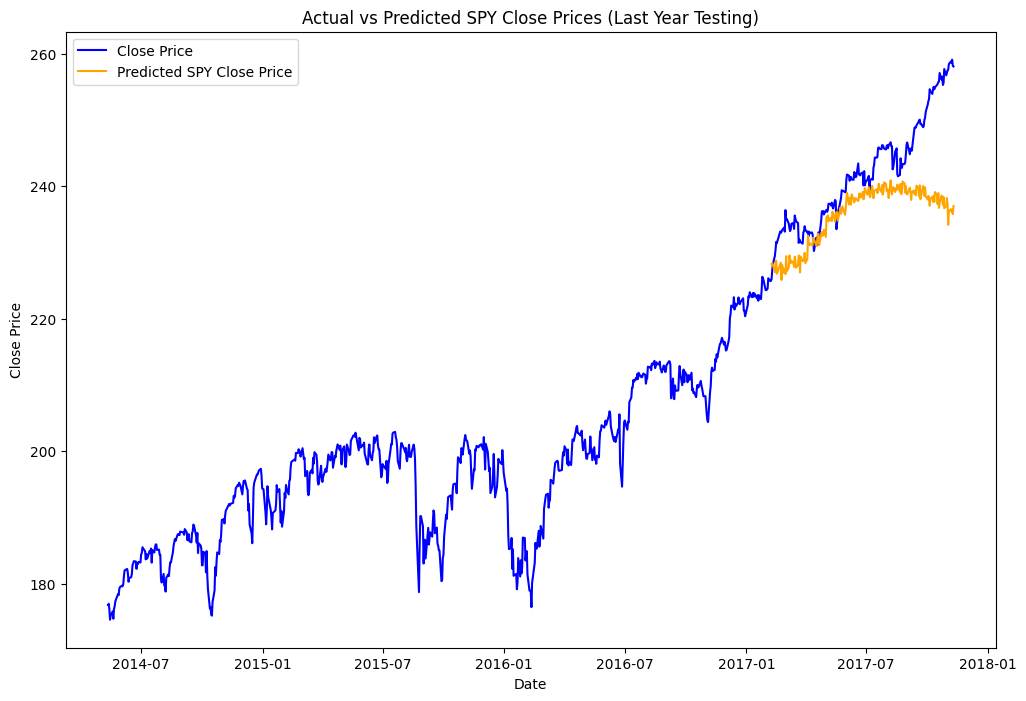

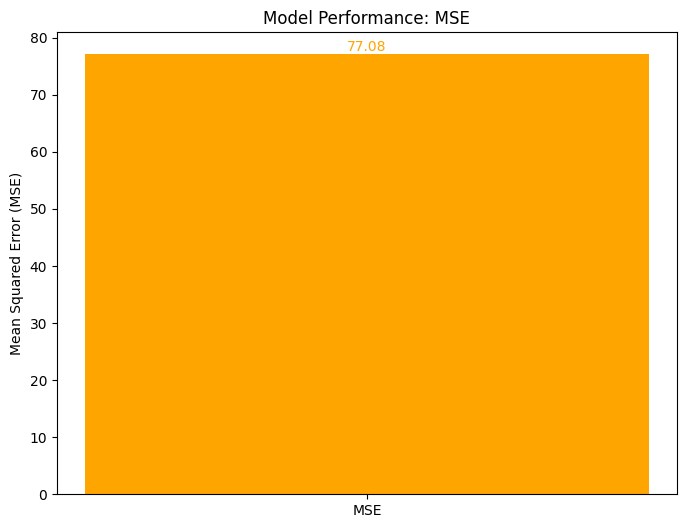

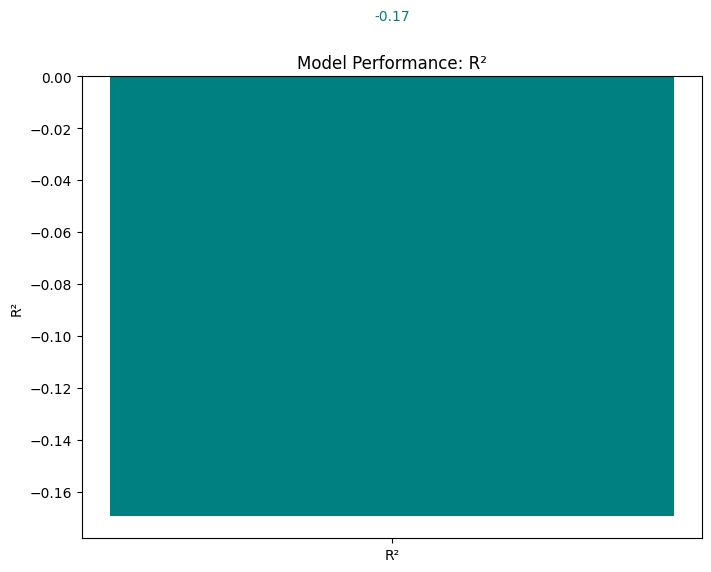

In [37]:
spy_predictions_tweaked = spy_predictions - 55

mse = mean_squared_error(y_spy_test_seq, spy_predictions_tweaked)
r2 = r2_score(y_spy_test_seq, spy_predictions_tweaked)
print(f"LSTM Model MSE on SPY Test Data (Last Year): {mse}")
print(f"LSTM Model R² on SPY Test Data (Last Year): {r2}")

# Plot results
plt.figure(figsize=(12, 8))
last_3_years = df.index[-1] - pd.DateOffset(months=3 * 12 + 6)
df_last_3_years = df[df.index >= last_3_years]
plt.plot(df_last_3_years.index, df_last_3_years['Close'], label='Close Price', color='blue')
plt.plot(spy_data.index[spy_data.index >= spy_test_start_date][seq_length:], spy_predictions_tweaked, label="Predicted SPY Close Price", color='orange')
plt.title("Actual vs Predicted SPY Close Prices (Last Year Testing)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

# Plot MSE
plt.figure(figsize=(8, 6))
bars_mse = plt.bar(['MSE'], [mse], color='orange')
plt.title('Model Performance: MSE')
plt.ylabel('Mean Squared Error (MSE)')
for bar in bars_mse:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, f'{yval:.2f}', ha='center', va='bottom', color='orange')  # Increased space
plt.show()

# Plot R-squared
plt.figure(figsize=(8, 6))
bars_r2 = plt.bar(['R²'], [r2], color='teal')
plt.title('Model Performance: R²')
plt.ylabel('R²')
for bar in bars_r2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.19, f'{yval:.2f}', ha='center', va='bottom', color='teal')  # Increased space
plt.show()